Input audio shape: (229317,), duration: 5.20 seconds
Detected silent gap from sample 204641 to 213461.
Processed audio shape: (229317,), duration: 5.20 seconds


/var/folders/yz/1fd13cns6gvbhv48blbqlsjh0000gn/T/ipykernel_14016/1517374373.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  audio[gap_start:gap_end] = lpc_signal


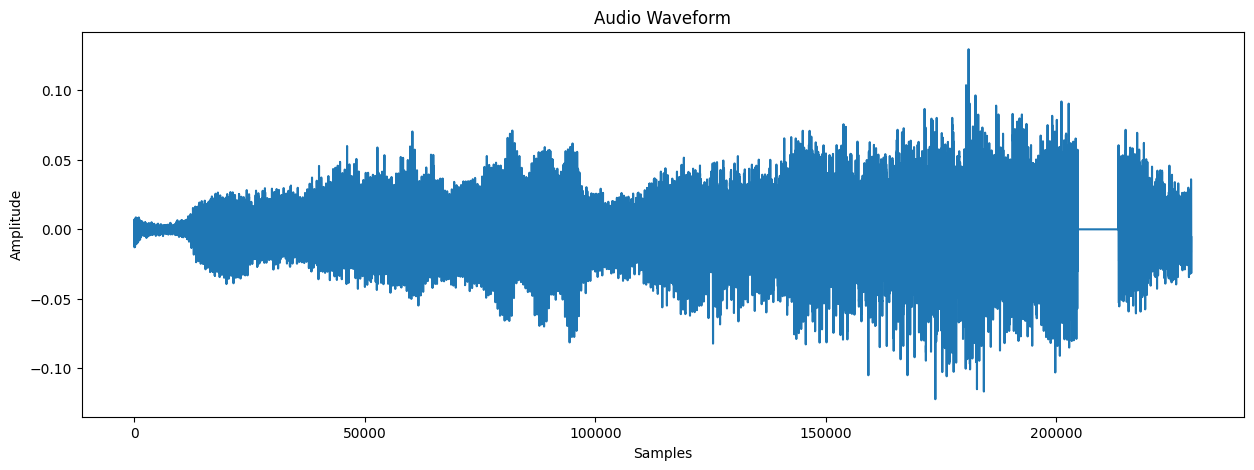

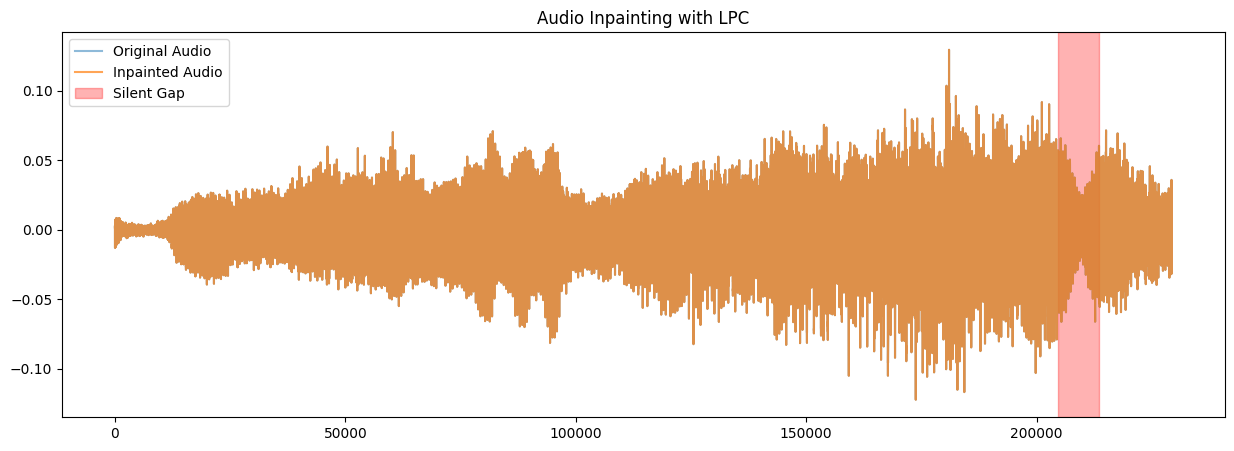

Original audio duration: 5.20 seconds
Inpainted audio duration: 5.20 seconds
Original Audio:


Inpainted Audio:


In [8]:
import os
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfiltic, lfilter
from IPython.display import Audio, display
from spectrum.burg import _arburg2

def detect_silent_gap(audio, sr, silence_duration_ms=200, threshold=0.001):
    silence_samples = int((silence_duration_ms / 1000) * sr)
    abs_audio = np.abs(audio)

    for i in range(len(audio) - silence_samples):
        window = abs_audio[i : i + silence_samples]
        if np.mean(window) < threshold:
            gap_start = i
            gap_end = i + silence_samples
            return gap_start, gap_end

    print("No sufficiently long silent gap found.")
    return None

def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order):
    target_length = gap_end - gap_start

    ab, _, _ = _arburg2(previous_sig, lpc_order)
    Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
    forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

    next_sig = np.flipud(next_sig)
    af, _, _ = _arburg2(next_sig, lpc_order)
    Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
    backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
    backw_pred = np.flipud(backw_pred)

    t = np.linspace(0, np.pi/2, target_length)
    sqCos = np.cos(t)**2
    sigout = sqCos * forw_pred + np.flipud(sqCos) * backw_pred
    return sigout

def inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order):
    context_size = 3000  
    previous_sig = audio[max(0, gap_start - context_size) : gap_start]
    next_sig = audio[gap_end : min(len(audio), gap_end + context_size)]

    if len(previous_sig) == 0 or len(next_sig) == 0:
        print("Insufficient context for LPC-based inpainting.")
        return audio

    lpc_signal = LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order)
    audio[gap_start:gap_end] = lpc_signal
    return audio

def process_audio_file_with_lpc(file_path, sr, lpc_order, silence_duration_ms=200, threshold=1e-4):
    audio, _ = torchaudio.load(file_path)
    audio = audio.squeeze().numpy()

    print(f"Input audio shape: {audio.shape}, duration: {len(audio) / sr:.2f} seconds")

    gap = detect_silent_gap(audio, sr, silence_duration_ms, threshold)
    if gap is None:
        return audio, audio, None, None

    gap_start, gap_end = gap
    print(f"Detected silent gap from sample {gap_start} to {gap_end}.")

    inpainted_audio = inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order)

    print(f"Processed audio shape: {inpainted_audio.shape}, duration: {len(inpainted_audio) / sr:.2f} seconds")
    return audio, inpainted_audio, gap_start, gap_end

def visualize_and_play(original, inpainted, gap_start, gap_end, sr):
    plt.figure(figsize=(15, 5))
    plt.plot(original, label="Original Audio", alpha=0.5)
    plt.plot(inpainted, label="Inpainted Audio", alpha=0.7)
    if gap_start is not None and gap_end is not None:
        plt.axvspan(gap_start, gap_end, color='red', alpha=0.3, label="Silent Gap")
    plt.legend()
    plt.title("Audio Inpainting with LPC")
    plt.show()

    print(f"Original audio duration: {len(original) / sr:.2f} seconds")
    print(f"Inpainted audio duration: {len(inpainted) / sr:.2f} seconds")

    print("Original Audio:")
    display(Audio(original, rate=sr))

    print("Inpainted Audio:")
    display(Audio(inpainted, rate=sr))

if __name__ == "__main__":
    file_path = '/Users/johannasmriti/Downloads/musicnet/data_with_gaps/1727_part11.wav'
    sr = 44100
    silence_duration_ms = 200
    lpc_order = 600

    original_audio, inpainted_audio, gap_start, gap_end = process_audio_file_with_lpc(
        file_path, sr, lpc_order, silence_duration_ms=silence_duration_ms
    )

    def plot_audio(audio, sr):
        plt.figure(figsize=(15, 5))
        plt.plot(audio)
        plt.title("Audio Waveform")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

    audio, _ = torchaudio.load(file_path)
    plot_audio(audio.squeeze().numpy(), sr)

    visualize_and_play(original_audio, inpainted_audio, gap_start, gap_end, sr)
